## Example 1

This example uses the supreme court corpus to compute some simple information:
- Which justices coordinate the most to others?
- Which justices are coordinated to the most?

In [1]:
import convokit

from convokit import Corpus

In [2]:
# OPTION 1: DOWNLOAD CORPUS
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = '<YOUR DIRECTORY>'
# ROOT_DIR = convokit.download('supreme-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE CORPUS IS LOCATED
# ROOT_DIR = '<YOUR DIRECTORY>'
ROOT_DIR = "/c/users/andrew/downloads/zissou.infosci.cornell.edu/convokit/datasets/oyez-corpus/oyez_2019/oyez_2019"

corpus = Corpus(ROOT_DIR)
#corpus = Corpus(filename=download("oyez_2019"))

In [3]:
# compute coordination scores on this corpus
coord = convokit.Coordination()
coord.fit(corpus)

# get coordination scores
coord.transform(corpus)

# get set of all justices
justices = lambda speaker: speaker.meta["type"] == "J"
# get set of all speakers
everyone = lambda speaker: True

# compute coordination from each justice to everyone
print("Justices, ranked by how much they coordinate to others:")
justices_to_everyone = coord.summarize(corpus, justices, everyone)
for justice, score in sorted(justices_to_everyone.averages_by_speaker().items(),
    key=lambda x: x[1], reverse=True):
    print(justice.id, round(score, 5))
print()

# compute coordination from everyone to each justice
print("Justices, ranked by how much others coordinate to them:")
everyone_to_justices = coord.summarize(corpus, everyone, justices, focus="targets")
for justice, score in sorted(everyone_to_justices.averages_by_speaker().items(), 
    key=lambda x: x[1], reverse=True):
    print(justice.id, round(score, 5))
print()

Justices, ranked by how much they coordinate to others:
j__samuel_a_alito_jr -0.00091
j__brett_m_kavanaugh -0.00231
j__stephen_g_breyer -0.00813
j__neil_gorsuch -0.01315
j__john_g_roberts_jr -0.01398
j__elena_kagan -0.01672
j__ruth_bader_ginsburg -0.01674
j__sonia_sotomayor -0.02873
j__clarence_thomas -0.09894

Justices, ranked by how much others coordinate to them:
j__clarence_thomas 0.148
j__elena_kagan 0.09479
j__ruth_bader_ginsburg 0.08881
j__brett_m_kavanaugh 0.06929
j__neil_gorsuch 0.05877
j__samuel_a_alito_jr 0.05741
j__sonia_sotomayor 0.0338
j__stephen_g_breyer 0.02377
j__john_g_roberts_jr 0.00862



##### Example 2

This example uses the supreme court corpus to reproduce figures 4 and 5 from
  the echoes of power paper (https://www.cs.cornell.edu/~cristian/Echoes_of_power.html).

The plots answer these questions:
- Do lawyers coordinate more to justices than the other way around?
- Do lawyers coordinate more to unfavorable or favorable justices?
- Do unfavorable justices coordinate to lawyers more than favorable justices,
    or vice versa?

In [4]:
from convokit import Utterance, Corpus, Coordination, download

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

%matplotlib inline

In [5]:
# helper function to plot two coordination scores against each other as a chart,
#   on aggregate and by coordination marker
# a is a tuple (speakers, targets)
# b is a tuple (speakers, targets)
def make_chart(a_scores, b_scores, a_description, b_description, a_color="b", b_color="g"):
    # get scores by marker and on aggregate
    a_score_by_marker = a_scores["marker_agg2"]
    a_agg1, a_agg2, a_agg3 = a_scores["agg1"], a_scores["agg2"], a_scores["agg3"]
    b_score_by_marker = b_scores["marker_agg2"]
    b_agg1, b_agg2, b_agg3 = b_scores["agg1"], b_scores["agg2"], b_scores["agg3"]

    # the rest plots this data as a double bar graph
    a_data_points = sorted(a_score_by_marker.items())
    b_data_points = sorted(b_score_by_marker.items())
    a_data_points, b_data_points = zip(*sorted(zip(a_data_points, b_data_points),
        key=lambda x: x[0][1], reverse=True))
    labels, a_data_points = zip(*a_data_points)
    _, b_data_points = zip(*b_data_points)

    labels = ["aggregate 1", "aggregate 2", "aggregate 3"] + list(labels)
    a_data_points = [a_agg1, a_agg2, a_agg3] + list(a_data_points)
    b_data_points = [b_agg1, b_agg2, b_agg3] + list(b_data_points)

    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(len(a_data_points)) + 0.35)
    ax.set_xticklabels(labels, rotation="vertical")

    ax.bar(np.arange(len(a_data_points)), a_data_points, 0.35, color=a_color)
    ax.bar(np.arange(len(b_data_points)) + 0.35, b_data_points, 0.35, color=b_color)

    b_patch = mpatches.Patch(color="b",
                             label=a_description + " (total: " +
                             str(a_scores["count_agg1"]) + ", " +
                             str(a_scores["count_agg2"]) + ")")
    g_patch = mpatches.Patch(color="g",
                             label=b_description + " (total: "  +
                             str(b_scores["count_agg1"]) + ", " +
                             str(b_scores["count_agg2"]) + ")")
    plt.legend(handles=[b_patch, g_patch])

    filename = str(a_description) + " vs " + str(b_description) + ".png"
    plt.savefig(filename, bbox_inches="tight")
    print('Created chart "' + filename + '"')

Created chart "Target-unfavorable justice vs Target-favorable justice.png"
Created chart "Speaker-unfavorable justice vs Speaker-favorable justice.png"


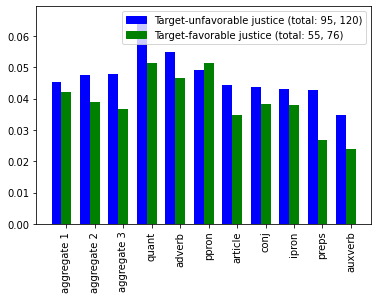

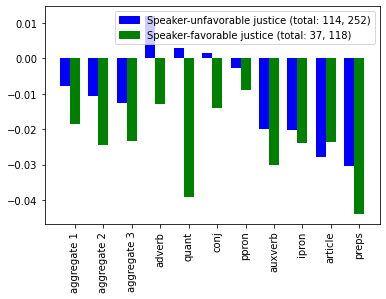

In [12]:
# split speakers by case id
# this treats the same person across two different cases as two different speakers
split = ["case_id"]

# create coordination object
coord = Coordination()
coord.fit(corpus)

# get all groups of speakers that we want to compare
everyone = lambda speaker: True
justices = lambda speaker: speaker.meta["type"] == "J"
lawyers = lambda speaker: speaker.meta["type"] == "A"

# filter out justice utterances, leaving only justices who voted on the same side as the advocates speaking to them
def target_justice_is_favorable(speaker_utt, target_utt):
    convo = speaker_utt.get_conversation()
    if convo.meta["votes_side"] is None: return False
    if speaker_utt.speaker.id not in convo.meta["advocates"]: return False
    lawyer_side = int(convo.meta["advocates"][speaker_utt.speaker.id]["side"])
    justice_side = int(convo.meta["votes_side"][target_utt.speaker.id])
    return justice_side == lawyer_side

def target_justice_is_unfavorable(speaker_utt, target_utt):
    return not target_justice_is_favorable(speaker_utt, target_utt)

# filter out justice utterances, leaving only justices who voted on the same side as the advocates they spoke to
def speaker_justice_is_favorable(speaker_utt, target_utt):
    convo = speaker_utt.get_conversation()
    if convo.meta["votes_side"] is None: return False
    if target_utt.speaker.id not in convo.meta["advocates"]: return False
    lawyer_side = int(convo.meta["advocates"][target_utt.speaker.id]["side"])
    justice_side = int(convo.meta["votes_side"][speaker_utt.speaker.id])
    return justice_side == lawyer_side

def speaker_justice_is_unfavorable(speaker_utt, target_utt):
    return not speaker_justice_is_favorable(speaker_utt, target_utt)

# do lawyers coordinate more to unfavorable or favorable justices?
make_chart(
    coord.summarize(corpus, lawyers, justices, summary_report=True,
                    target_thresh=6, speaker_thresh=6, split_by_attribs=split,
                    target_utterance_selector=target_justice_is_unfavorable),
    coord.summarize(corpus, lawyers, justices, summary_report=True,
                    target_thresh=6, speaker_thresh=6, split_by_attribs=split,
                    target_utterance_selector=target_justice_is_favorable),
    "Target-unfavorable justice", "Target-favorable justice"
)
# do unfavorable justices coordinate to lawyers more than favorable justices, or
#   vice versa?
make_chart(
    coord.summarize(corpus, justices, lawyers, summary_report=True,
                    target_thresh=6, split_by_attribs=split,
                    speaker_utterance_selector=speaker_justice_is_unfavorable),
    coord.summarize(corpus, justices, lawyers, summary_report=True,
                    target_thresh=6, split_by_attribs=split,
                    speaker_utterance_selector=speaker_justice_is_favorable),
    "Speaker-unfavorable justice", "Speaker-favorable justice"
)

## Example 3

This example uses the wikipedia conversations corpus to reproduce figure 1
  from the echoes of power paper (https://www.cs.cornell.edu/~cristian/Echoes_of_power.html).

The plots answer these questions: 
- Do speakers on the whole coordinate more to admins or nonadmins?
- Do admins coordinate to other people more than nonadmins do?

In [21]:
# OPTION 1: DOWNLOAD CORPUS
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = '<YOUR DIRECTORY>'
# ROOT_DIR = convokit.download('wiki-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE CORPUS IS LOCATED
# ROOT_DIR = '<YOUR DIRECTORY>'

corpus = Corpus(ROOT_DIR)
split = ["is-admin"]

Created chart "Target-admins vs Target-nonadmins.png"
Created chart "Speaker-admins vs Speaker-nonadmins.png"


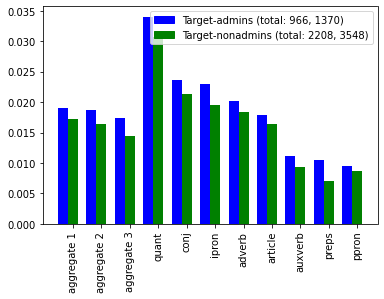

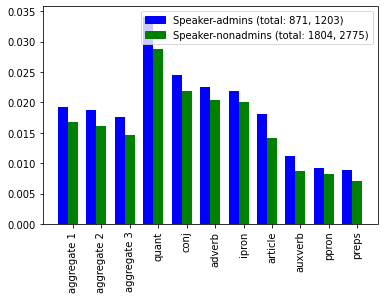

In [24]:
# create coordination object
coord = Coordination()
coord.fit(corpus)

# get all groups of speakers that we want to compare
everyone = lambda speaker: True
admins = lambda speaker: speaker.meta["is-admin"]
nonadmins = lambda speaker: not speaker.meta["is-admin"]

# do speakers on the whole coordinate more to admins or nonadmins?
make_chart(
    coord.summarize(corpus, everyone, admins, focus="targets", summary_report=True,
                    target_thresh=7, split_by_attribs=split),
    coord.summarize(corpus, everyone, nonadmins, focus="targets", summary_report=True,
                    target_thresh=7, split_by_attribs=split),
    "Target-admins", "Target-nonadmins"
)
# do admins coordinate to other people more than nonadmins do?
make_chart(
    coord.summarize(corpus, admins, everyone, summary_report=True,
                    speaker_thresh=7, target_thresh=7, split_by_attribs=split),
    coord.summarize(corpus, nonadmins, everyone, summary_report=True,
                    speaker_thresh=7, target_thresh=7, split_by_attribs=split),
    "Speaker-admins", "Speaker-nonadmins"
)